In [111]:
# setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# define style do seaborn
sns.set_style('whitegrid')

In [112]:
# carrega o dataset tratado
df_br = pd.read_csv('../data/brasileirao_2014_2024_clean.csv', index_col=0)

# exibe informações sobre o dataframe
df_br.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3800 entries, 0 to 4085
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ano_campeonato          3800 non-null   int64  
 1   rodada                  3800 non-null   int64  
 2   estadio                 3800 non-null   object 
 3   publico                 3800 non-null   float64
 4   publico_max             3800 non-null   float64
 5   arbitro                 3800 non-null   object 
 6   time_mandante           3800 non-null   object 
 7   gols_mandante           3800 non-null   float64
 8   time_visitante          3800 non-null   object 
 9   gols_visitante          3800 non-null   float64
 10  escanteios_mandante     1880 non-null   float64
 11  escanteios_visitante    1880 non-null   float64
 12  faltas_mandante         1880 non-null   float64
 13  faltas_visitante        1880 non-null   float64
 14  impedimentos_mandante   1880 non-null   float

In [113]:
# define o vencedor com base nos gols e atribui "empate" se os gols forem iguais
df_br['vencedor'] = np.select(
    [df_br['gols_mandante'] > df_br['gols_visitante'], df_br['gols_mandante'] < df_br['gols_visitante']],
    [df_br['time_mandante'], df_br['time_visitante']],
    default='Empate'
)

# cálcula a quantidade de pontos feitos como mandante/visitante
# vitória = 3 pontos; empate = 1 ponto; derrota = 0 pontos
df_br['pontos_mandante'] = np.select(
    [df_br['vencedor'] == df_br['time_mandante'], df_br['vencedor'] == 'Empate'],
    [3, 1],
    default=0
)

df_br['pontos_visitante'] = np.select(
    [df_br['vencedor'] == df_br['time_visitante'], df_br['vencedor'] == 'Empate'],
    [3, 1],
    default=0
)

In [114]:
# calculo da taxa de aproveitamento dos times
# pontos conquistados (ponderação de vitórias ou empates) dividido pelo total de pontos disputados (partidas * 3)
df_pontos = pd.concat([
    df_br[['time_mandante', 'pontos_mandante']].rename(columns={'time_mandante': 'time', 'pontos_mandante': 'pontos'}),
    df_br[['time_visitante', 'pontos_visitante']].rename(columns={'time_visitante': 'time', 'pontos_visitante': 'pontos'})
])

df_pontos = (
    df_pontos
    .groupby('time')
    .agg(
        partidas=('pontos', 'size'),
        pontos_conquistados=('pontos', 'sum')        
    )
    .assign(
        pontos_disputados=lambda df: df['partidas'] * 3,
        taxa_aproveitamento=lambda df: df['pontos_conquistados'] / df['pontos_disputados']
    )
    .sort_values(by='taxa_aproveitamento', ascending=False)
    .reset_index()
)

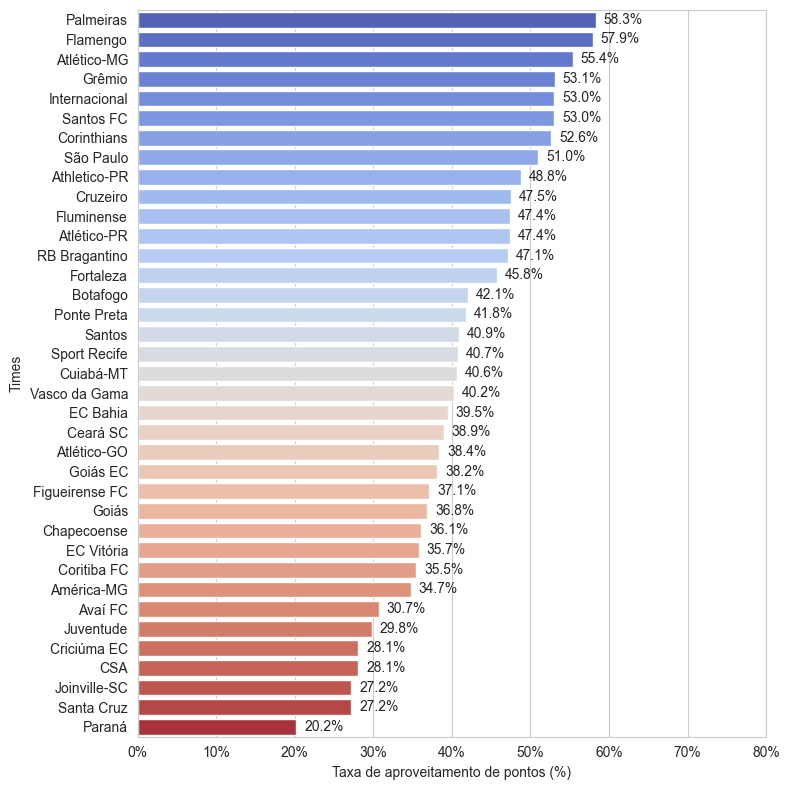

In [137]:
# visualização da taxa de aproveitamento geral
# considera todos os times que disputaram o campeonato brasileiro no período
plt.figure(figsize=(8, 8))

sns.barplot(
    data=df_pontos,
    x='taxa_aproveitamento',
    y='time',
    hue='time',
    palette='coolwarm'
)

for i, (taxa) in enumerate(df_pontos['taxa_aproveitamento']):
    plt.text(taxa + 0.01, i, f'{taxa:.1%}', va='center', fontsize=10)

plt.xlabel('Taxa de aproveitamento de pontos (%)')
plt.ylabel('Times')

plt.xlim(0, 0.8)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.show()

In [ ]:
# calculo da taxa de aproveitamento ESPECÍFICA do par time, árbitro
df_arbitros = pd.concat([
    df_br[['arbitro', 'time_mandante', 'pontos_mandante']].rename(columns={'time_mandante': 'time', 'pontos_mandante': 'pontos'}),
    df_br[['arbitro', 'time_visitante', 'pontos_visitante']].rename(columns={'time_visitante': 'time', 'pontos_visitante': 'pontos'})
])

df_arbitros = (
    df_arbitros
    .groupby(['arbitro', 'time'])
    .agg(
        partidas=('pontos', 'size'),
        pontos_conquistados=('pontos', 'sum')        
    )
    .assign(
        pontos_disputados=lambda df: df['partidas'] * 3,
        taxa_aproveitamento=lambda df: df['pontos_conquistados'] / df['pontos_disputados']
    )
    .reset_index()
)

# junção da base com a taxa de aproveitamento geral dos times
df_arbitros = pd.merge(df_arbitros, df_pontos, on='time', suffixes=('_arbitro', '_geral'))

# criação de variável que mede o desvio do aproveitamento específico em relação a média geral
# métrica definida em pontos percentuais
df_arbitros['taxa_aproveitamento_desvio'] = (df_arbitros['taxa_aproveitamento_arbitro'] - df_arbitros['taxa_aproveitamento_geral']) * 100

In [175]:
# lista de 20 times com maior número de jogos pelo Brasileirão no período
top_times = df_pontos.sort_values('partidas', ascending=False).head(20)['time'].tolist()

# lista de 10 árbitros com maior número de jogos pelo Brasileirão no período
top_arbitros = df_br['arbitro'].value_counts().head(10).index.tolist()

# gera matriz de desvio na taxa de aproveitamento dos times com os árbitros
# filtra principais times e árbitros
# também filtra árbitros que apitaram pelo menos 5 jogos com cada time
matriz_desvio_arbitros = (
    df_arbitros
    .query('time in @top_times')
    .query('arbitro in @top_arbitros')
    .query('partidas_arbitro > 5')
    .pivot(index='time', columns='arbitro', values='taxa_aproveitamento_desvio')
)

# matriz com o número de partidas dos times com cada árbitro
matriz_partidas_arbitros = (
    df_arbitros
    .query('time in @top_times')
    .query('arbitro in @top_arbitros')
    .query('partidas_arbitro > 5')
    .pivot(index='time', columns='arbitro', values='partidas_arbitro')
)

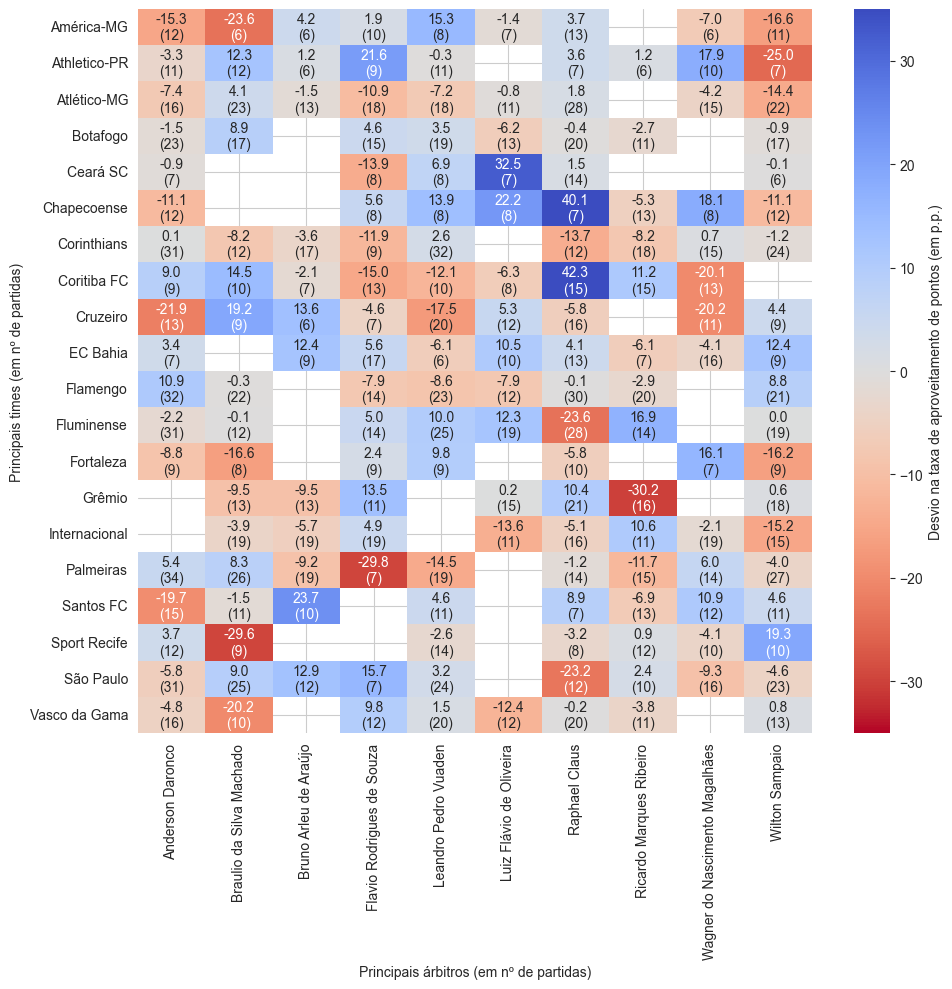

In [184]:
# annotation do plot: desvio na taxa de aproveitamento (número de partidas do árbitro com o time)
annot_data = matriz_desvio_arbitros.copy().astype('object')

for i in range(matriz_desvio_arbitros.shape[0]):
    for j in range(matriz_desvio_arbitros.shape[1]):
        desvio = matriz_desvio_arbitros.iat[i, j]
        partidas = matriz_partidas_arbitros.iat[i, j]
        if pd.notnull(desvio) and pd.notnull(partidas):
            annot_data.iat[i, j] = f'{desvio:.1f}\n({int(partidas)})'
        else:
            annot_data.iat[i, j] = ''

# visualização da matriz de desvio na taxa de aproveitamento dos times com os árbitros
plt.figure(figsize=(10, 10))

sns.heatmap(
    data=matriz_desvio_arbitros, 
    annot=annot_data,
    fmt='',
    cmap='coolwarm_r',
    cbar_kws={'label': 'Desvio na taxa de aproveitamento de pontos (em p.p.)'},
    center=0,
    vmax=35,
    vmin=-35
)

plt.xlabel('Principais árbitros (em nº de partidas)')
plt.ylabel('Principais times (em nº de partidas)')

plt.tight_layout()
plt.show()

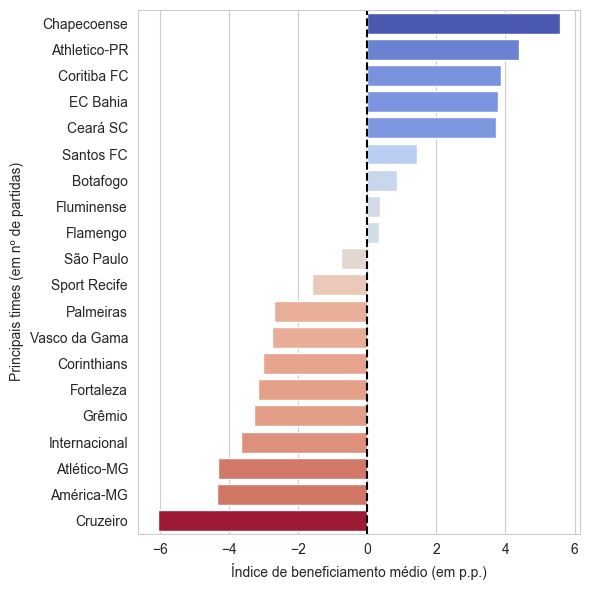

In [194]:
# multiplica as matrizes para gerar uma métrica geral de beneficiamento dos times
# ponderação pelo número de partidas que cada árbitro apitou para o time
beneficio_index = (matriz_desvio_arbitros * matriz_partidas_arbitros).sum(axis=1) / matriz_partidas_arbitros.sum(axis=1)

beneficio_index = beneficio_index.reset_index()
beneficio_index.columns = ['time', 'indice_beneficiamento']
beneficio_index = beneficio_index.sort_values('indice_beneficiamento', ascending=False)

# visualização ordenada do índice de beneficiamento geral dos times
# agregação dos 20 principais times vs 10 principais árbitros
plt.figure(figsize=(6, 6))

sns.barplot(
    data=beneficio_index,
    y='time',
    x='indice_beneficiamento',
    hue='indice_beneficiamento',
    palette='coolwarm_r',
    legend=False
)

plt.axvline(0, color='black', linestyle='--')
plt.ylabel('Principais times (em nº de partidas)')
plt.xlabel('Índice de beneficiamento médio (em p.p.)')

plt.tight_layout()
plt.show()
